In [2]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
sys.path.insert(1, '/home/xionglei/yanqiu/')
#from scale_plot_feature import read_mtx

In [3]:
import matplotlib
%matplotlib inline
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [33]:
import matplotlib.pyplot as plt

In [5]:
rna=read_mtx('/home/xionglei/data/joint_ATAC_RNA/SNARE-seq/AdBrainCortex/RNA/')
rna_adata=sc.AnnData(rna.T)
sc.pp.filter_cells(rna_adata, min_genes=100)
sc.pp.filter_genes(rna_adata, min_cells=10)

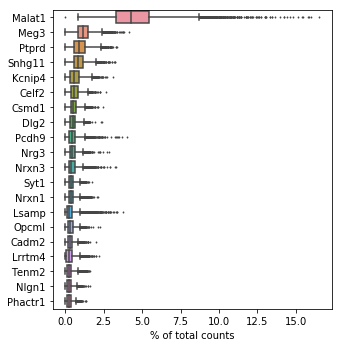

In [22]:
sc.pl.highest_expr_genes(rna_adata, n_top=20)

In [6]:
sc.pp.normalize_per_cell(rna_adata, counts_per_cell_after=1e4)
sc.pp.log1p(rna_adata)
rna_adata.raw = rna_adata
sc.pp.highly_variable_genes(rna_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
rna_adata = rna_adata[:, rna_adata.var['highly_variable']]
rna_adata.shape

(10309, 3620)

In [8]:
atac=read_mtx('/home/xionglei/data/joint_ATAC_RNA/SNARE-seq/AdBrainCortex/ATAC/')
atac_adata=sc.AnnData(atac.T)
sc.pp.filter_cells(atac_adata, min_genes=100)
sc.pp.filter_genes(atac_adata, min_cells=10)
atac_adata.shape

(10309, 204268)

In [9]:
barcodes=list(set(rna_adata.obs_names)&set(atac_adata.obs_names))
rn=rna_adata[barcodes, :]
an=atac_adata[barcodes, :]

Trying to set attribute `.obs` of view, making a copy.


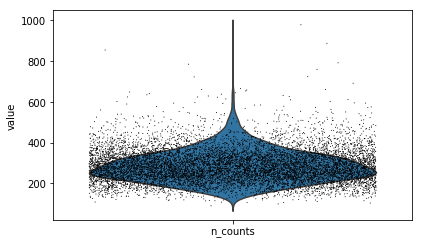

In [47]:
rn.obs['n_counts'] = rn.X.sum(axis=1)
sc.pl.violin(rn, 'n_counts',jitter=0.4)

Trying to set attribute `.obs` of view, making a copy.


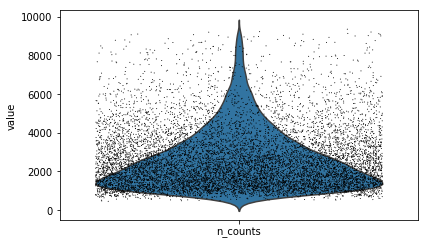

In [48]:
an.obs['n_counts'] = an.X.sum(axis=1)
sc.pl.violin(an, 'n_counts',jitter=0.4)

In [10]:
sc.pp.normalize_per_cell(an, counts_per_cell_after=1e4)
sc.pp.log1p(an)

Trying to set attribute `.obs` of view, making a copy.


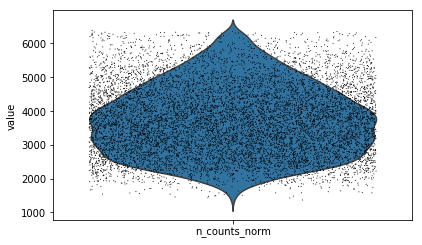

In [11]:
an.obs['n_counts_norm'] = an.X.sum(axis=1)
sc.pl.violin(an, 'n_counts_norm',jitter=0.4)

In [71]:
an.raw = an
sc.pp.highly_variable_genes(an, min_mean=0.0125, max_mean=3, min_disp=0.5)
len(an.var['highly_variable'][an.var['highly_variable']])

33695

In [ ]:
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix

In [13]:
rn.write('SNARE-seq/ad/rn.h5ad')

In [14]:
an.write('SNARE-seq/ad/an.h5ad')

In [4]:
rn=sc.read_h5ad('SNARE-seq/cellline_meta/rn.h5ad')
an=sc.read_h5ad('SNARE-seq/cellline_meta/an.h5ad')

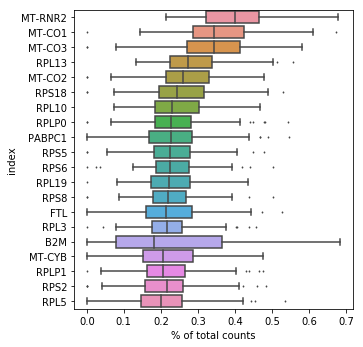

In [12]:
sc.pl.highest_expr_genes(rn, n_top=20)

In [26]:
weights=rn.obs['Weights']

# read gene_info

In [9]:
import pickle
gene_info = pickle.load(open('lib/gene_info_hg.pkl', 'rb'))

In [10]:
gene_info.keys()

dict_keys(['gene_bins', 'genes_to_exons', 'gene_starts', 'gene_ends', 'gene_id_to_name', 'gene_id_to_genome', 'gene_id_to_chrom', 'gene_id_to_strand', 'gene_id_to_biotype'])

In [11]:
gene_id_to_name=gene_info['gene_id_to_name']
gene_name_to_id={}
for gene_id in gene_id_to_name.keys():
        gene_name=gene_id_to_name[gene_id]
        gene_name_to_id.setdefault(gene_name,[])    
        gene_name_to_id[gene_name].append(gene_id)
        gene_name_to_id.setdefault(gene_id.split('.')[0],[])
        gene_name_to_id[gene_id.split('.')[0]].append(gene_id)
gene_id_to_chrom=gene_info['gene_id_to_chrom']
gene_starts=gene_info['gene_starts']
gene_ends=gene_info['gene_ends']

In [13]:
gene_name_to_id['MT-RNR2']

['ENSG00000210082.2']

In [18]:
gene_around_peaks=pickle.load(open('SNARE-seq/cellline_meta/gene_around_peaks_250k.pkl','rb'))

In [20]:
gene='RPL13'
peaks=gene_around_peaks[gene]
peaks

['chr16:89564729-89565981',
 'chr16:89700082-89700518',
 'chr16:89657413-89658164',
 'chr16:89574455-89574954',
 'chr16:89720585-89721776',
 'chr16:89505471-89505720',
 'chr16:89686487-89687548',
 'chr16:89816157-89817132',
 'chr16:89557402-89557748',
 'chr16:89602200-89602766',
 'chr16:89321029-89321558',
 'chr16:89489180-89489707',
 'chr16:89430947-89431524',
 'chr16:89322435-89322984',
 'chr16:89701413-89702303',
 'chr16:89490365-89491001',
 'chr16:89507611-89508926',
 'chr16:89560327-89560777',
 'chr16:89706020-89706258',
 'chr16:89700982-89701201']

In [151]:
import time
start_time = time.time()
around_peaks=get_around_peaks('Cass4', 500000, an.var_names)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.35239553451538086 seconds ---


In [153]:
import scipy.stats as stats
cor=[]
pval=[]
for peak in around_peaks:
    c,p=stats.pearsonr(rn.obs_vector(gene), an.obs_vector(peak))
    cor.append(c)
    pval.append(p)

In [ ]:
df={}
for peak in peaks:
    df[peak]=an.obs_vector(peak)
X = pd.DataFrame(df)
y = rn.obs_vector(gene)

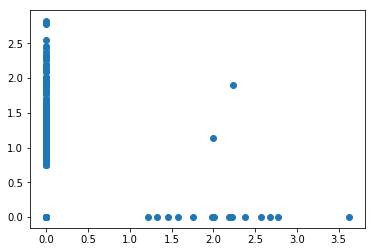

In [158]:
plt.scatter(rn.obs_vector(gene), an.obs_vector('chr2:172127462-172127872'))

In [162]:
from sklearn import linear_model

In [165]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
print(lm.score(X,y)) # R square
print(lm.coef_)
#lm.intercept_
#predictions = lm.predict(X)

0.007421298368818662
[-0.0018649  -0.00488613 -0.0022828  -0.00450957 -0.00521552 -0.00071825
 -0.00246986 -0.00161358  0.00974656 -0.00165647  0.00719292 -0.00208021
  0.01738183  0.00065739  0.00428167  0.01216844  0.01231345 -0.00048104
 -0.00219102 -0.00536582 -0.00149586 -0.00318631 -0.00177036 -0.00183804
 -0.00184285 -0.0016487  -0.00219434 -0.00354805 -0.00137544 -0.00030607
 -0.00141153 -0.00246142 -0.00095359  0.00155658 -0.00329824 -0.00230696
 -0.00068083 -0.00267342 -0.00104336 -0.00247291 -0.00225551  0.007733
 -0.00214888 -0.00099007 -0.00139132 -0.0016484  -0.00278208 -0.00196888
 -0.001112   -0.00125089 -0.0014172  -0.00194381 -0.00187293 -0.00134608
  0.00324632 -0.00315594 -0.00047033 -0.00400801 -0.00161311 -0.00138239
 -0.00236945 -0.00199002 -0.00246436 -0.00307772 -0.00195253 -0.00263373
 -0.00072439 -0.00147414 -0.00217785 -0.00122948  0.03427069 -0.00171231
 -0.00132544 -0.00181458 -0.00079663 -0.00194918 -0.0006304  -0.002671
 -0.01191499  0.01872955 -0.002722

In [27]:
import statsmodels.api as sm
from scipy import stats

est = sm.WLS(y, X, weights=weights).fit()
print(est.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.680
Model:                            WLS   Adj. R-squared (uncentered):              0.632
Method:                 Least Squares   F-statistic:                              14.12
Date:                Fri, 18 Oct 2019   Prob (F-statistic):                    5.68e-24
Time:                        18:48:07   Log-Likelihood:                         -335.82
No. Observations:                 153   AIC:                                      711.6
Df Residuals:                     133   BIC:                                      772.2
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [30]:
predictions = est.predict(X)

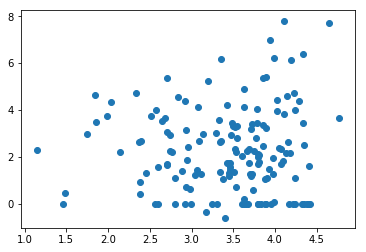

In [34]:
plt.scatter(y, predictions)

In [207]:
basic=est.summary2().tables[0]
coefs=est.summary2().tables[1]
R2=float(basic.iloc[6,1])
R2_adj=float(basic.iloc[0,3])
coefs=coefs.astype('float')
coefs[coefs['P>|t|']<0.05].sort_values('Coef.', ascending=False)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
chr2:172758336-172758887,0.034835,0.008042,4.331567,0.000015,0.019071,0.050599
chr2:172825242-172825506,0.019348,0.008769,2.206330,0.027383,0.002158,0.036537
chr2:172127462-172127872,0.017953,0.004764,3.768673,0.000165,0.008615,0.027291
chr2:172345189-172345834,0.008367,0.001781,4.697541,0.000003,0.004875,0.011858


In [ ]:
predictions = lm.predict(X)
print(predictions)[0:5]

In [106]:
gene_peaks={}
for gene in rn.var_names:
    gene_peaks[gene]=[]
    try:
        peaks=get_around_peaks(gene, 250000, an.var_names)
        gene_peaks[gene]=peaks
    except:
        print(gene, 'has no valid annotation...')

1110007C09Rik has no valid annotation...
1700019G17Rik has no valid annotation...
1700084C01Rik has no valid annotation...
1700123I01Rik has no valid annotation...
2610015P09Rik has no valid annotation...
3110052M02Rik has no valid annotation...
4632428N05Rik has no valid annotation...
4930448N21Rik has no valid annotation...
4930533O14Rik has no valid annotation...
4932411E22Rik has no valid annotation...
5031414D18Rik has no valid annotation...
AA474331 has no valid annotation...
AF251705 has no valid annotation...
AI854517 has no valid annotation...
Adrbk2 has no valid annotation...
Athl1 has no valid annotation...
CAAA01147332.1 has no valid annotation...
Ccbl2 has no valid annotation...
Ccdc55 has no valid annotation...
Ccdc67 has no valid annotation...
Cdc34-ps has no valid annotation...
Cml1 has no valid annotation...
Cml3 has no valid annotation...
D8Ertd82e has no valid annotation...
Ddx26b has no valid annotation...
Erbb2ip has no valid annotation...
Fam21 has no valid annota

In [107]:
with open('SNARE-seq/ad/gene_around_peaks_250k.pkl', 'wb') as f:
    pickle.dump(gene_peaks, f)  

In [109]:
gene_peak_counts={}
for gene in gene_peaks:
    if gene_peaks[gene]:
        gene_peak_counts[gene]=len(gene_peaks[gene])

In [110]:
print(len(list(gene_peak_counts.keys())))

3545


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5914950940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5304f728d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f53034269b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5304f72358>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f52ffbb76a0>],
 'means': []}

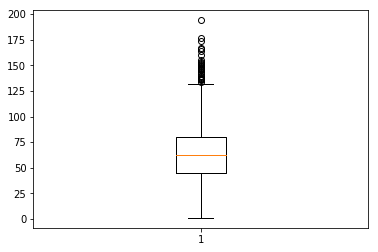

In [111]:
import matplotlib.pyplot as plt
plt.boxplot(gene_peak_counts.values())

Text(0, 0.5, 'counts')

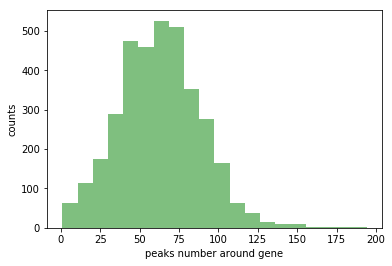

In [116]:
n, bins, patches = plt.hist(gene_peak_counts.values(), 20, facecolor='green', alpha=0.5)
plt.xlabel('peaks number around gene')
plt.ylabel('counts')